2025-08-01 16:44:16.960071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 16:44:16.972768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 16:44:17.070758: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 16:44:17.152992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754077457.239815    5459 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754077457.26

Found 7662 validated image filenames.
Found 1351 validated image filenames.
Found 1002 validated image filenames.


2025-08-01 16:44:24.594894: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Iniciando treinamento...


/home/gustavson-barros/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 430s 876ms/step - accuracy: 0.1160 - loss: 4.6260 - val_accuracy: 0.0164 - val_loss: 3.9190 - learning_rate: 0.0010
Epoch 2/100
  1/478 ━━━━━━━━━━━━━━━━━━━━ 4:37 581ms/step - accuracy: 0.1250 - loss: 3.0680

/home/gustavson-barros/anaconda3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


478/478 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.1250 - loss: 3.0680 - val_accuracy: 0.0164 - val_loss: 3.9189 - learning_rate: 0.0010
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 412s 862ms/step - accuracy: 0.1241 - loss: 4.0763 - val_accuracy: 0.0112 - val_loss: 3.8234 - learning_rate: 0.0010
Epoch 4/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.0625 - loss: 2.5988 - val_accuracy: 0.0104 - val_loss: 3.8269 - learning_rate: 0.0010
Epoch 5/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 413s 864ms/step - accuracy: 0.1129 - loss: 3.6871 - val_accuracy: 0.0164 - val_loss: 3.4617 - learning_rate: 0.0010
Epoch 6/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 60s 125ms/step - accuracy: 0.1250 - loss: 5.6312 - val_accuracy: 0.0164 - val_loss: 3.4622 - learning_rate: 0.0010
Epoch 7/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 412s 861ms/step - accuracy: 0.1071 - loss: 3.4263 - val_accuracy: 0.1034 - val_loss: 3.0498 - learning_rate: 0.0010
Epoch 8/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 60s 125ms/step - accuracy: 0.000

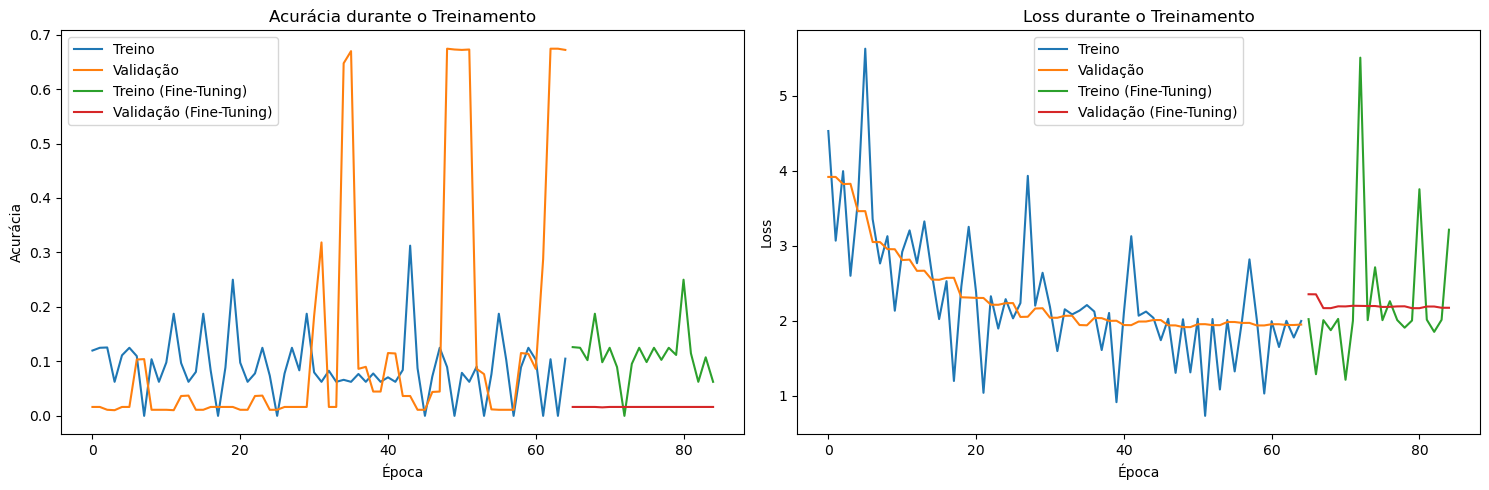


Modelo final salvo como 'skin_cancer_model_final.keras'


In [1]:
# ======================
# 1. IMPORTAR BIBLIOTECAS
# ======================
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ===========================
# 2. CONFIGURAÇÃO INICIAL
# ===========================
# Configurações
base_path = '/home/gustavson-barros/dermai-system/datasetHAM1000/archive'
batch_size = 16  # Batch size reduzido para melhor generalização
img_size = (224, 224)
epochs = 100  # Número maior de épocas

# ===========================
# 3. PREPARAÇÃO DOS DADOS
# ===========================
# Carregar e preparar metadados
metadata = pd.read_csv(f'{base_path}/HAM10000_metadata.csv')
label_mapping = {'akiec':0, 'bcc':1, 'bkl':2, 'df':3, 'mel':4, 'nv':5, 'vasc':6}
metadata['label'] = metadata['dx'].map(label_mapping)

# Localizar imagens
def find_image_path(image_id):
    for folder in ['ham10000_images_part_1', 'ham10000_images_part_2', 
                   'HAM10000_images_part_1', 'HAM10000_images_part_2']:
        path = f'{base_path}/{folder}/{image_id}.jpg'
        if os.path.exists(path):
            return path
    return None

metadata['image_path'] = metadata['image_id'].apply(find_image_path)
valid_metadata = metadata[metadata['image_path'].notnull()]

# Dividir dados
train_df, test_df = train_test_split(
    valid_metadata, 
    test_size=0.1,  
    stratify=valid_metadata['label'], 
    random_state=42
)

# Calcular pesos das classes
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_df['label']),
                                   y=train_df['label'])
class_weights = dict(enumerate(class_weights))

# ===========================
# 4. DATA GENERATORS OTIMIZADOS
# ===========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9,1.1],
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Criar generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

# ===========================
# 5. ARQUITETURA DO MODELO OTIMIZADA
# ===========================
# Carregar EfficientNet pré-treinada
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(*img_size, 3),
    pooling='avg'  # Já faz average pooling
)

# Congelar camadas base
for layer in base_model.layers:
    layer.trainable = False

# Construir modelo personalizado
inputs = tf.keras.Input(shape=(*img_size, 3))
x = base_model(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

# Compilar com otimização melhorada
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks melhorados
callbacks = [
    ModelCheckpoint('best_model.keras', 
                  monitor='val_accuracy', 
                  save_best_only=True, 
                  mode='max'),
    EarlyStopping(monitor='val_loss', 
                 patience=15, 
                 restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', 
                     factor=0.5, 
                     patience=5, 
                     min_lr=1e-7),
    TensorBoard(log_dir='./logs')
]

# ===========================
# 6. TREINAMENTO OTIMIZADO
# ===========================
print("\nIniciando treinamento...")
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ===========================
# 7. FINE-TUNING
# ===========================
# Descongelar as últimas camadas para fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompilar com learning rate menor
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nIniciando fine-tuning...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ===========================
# 8. AVALIAÇÃO E RESULTADOS
# ===========================
# Avaliar no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nAcurácia no Teste: {test_acc:.4f}')
print(f'Loss no Teste: {test_loss:.4f}')

# Plotar desempenho
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
if 'history_fine' in locals():
    plt.plot([x + len(history.history['accuracy']) for x in range(len(history_fine.history['accuracy']))], 
             history_fine.history['accuracy'], label='Treino (Fine-Tuning)')
    plt.plot([x + len(history.history['val_accuracy']) for x in range(len(history_fine.history['val_accuracy']))], 
             history_fine.history['val_accuracy'], label='Validação (Fine-Tuning)')
plt.title('Acurácia durante o Treinamento')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
if 'history_fine' in locals():
    plt.plot([x + len(history.history['loss']) for x in range(len(history_fine.history['loss']))], 
             history_fine.history['loss'], label='Treino (Fine-Tuning)')
    plt.plot([x + len(history.history['val_loss']) for x in range(len(history_fine.history['val_loss']))], 
             history_fine.history['val_loss'], label='Validação (Fine-Tuning)')
plt.title('Loss durante o Treinamento')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()

# Salvar modelo final
model.save('skin_cancer_model_final.keras')
print("\nModelo final salvo como 'skin_cancer_model_final.keras'")